#### Deep Learning Models: AlexNet

We will be using a Model baseed on AlexNet

In [ ]:
import os
import nibabel as nib
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import time

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input 
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Activation
# from keras.layers import Conv2D, MaxPooling2D
# from keras.models import Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils.np_utils import to_categorical
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.applications import resnet, inception_resnet_v2, inception_v3, densenet, vgg16, vgg19
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Loading Dataset - Short Format

In [ ]:
X_train = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/X_train.npy")
X_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/X_test.npy")
y_train = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/y_train.npy")
y_test = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Long Format/y_test.npy")

In [ ]:
y_test_short = np.load("/content/gdrive/My Drive/Colab Notebooks/TFM/Data/Short Format/y_test_array.npy")

In [ ]:
y_test_ = [np.argmax(y_test_short[x,:]) for x in range(50)]

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True, stratify=y_train )

In [ ]:
inp_shape = X_train2.shape[1:]

#### Data Augmentation 

In [ ]:
#Data Augmentation Set Up 
train_gen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='constant')


####Optimizers

In [ ]:
#Optimzers
sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

####Model and Training

In [ ]:
model = Sequential()

model.add(Conv2D(96, (11, 11), strides = (4,4), padding='valid', activation='relu', input_shape = inp_shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

model.add(Conv2D(256, (5, 5), strides=(1,1), padding="same", activation='relu', dilation_rate=2))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

model.add(Conv2D(384, (3, 3), strides=(1,1), padding="same", activation='relu', dilation_rate=2))
model.add(Conv2D(384, (3, 3), strides=(1,1), padding="same", activation='relu', dilation_rate=2))
model.add(Conv2D(256, (3, 3), strides=(1,1), padding="same", activation='relu', dilation_rate=2))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(9216, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 35, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         8

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

NAME = 'AlexNet'

filepathdest_incep = "/content/gdrive/My Drive/Colab Notebooks/TFM/Models/"+NAME+".hdf5"

callback_setting = [ModelCheckpoint(filepath=filepathdest_incep, verbose=1, monitor='val_accuracy', mode='max', save_best_only=True)]

log_dir = "logs/fit/" + NAME +' ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=False)

history = model.fit(train_gen.flow(X_train2, y_train2),
                    batch_size=50,                 
                    epochs=650,
                    verbose=1,
                    callbacks=[callback_setting, tensorboard_callback],
                    validation_data=(X_val2,y_val2)
                   )

Epoch 1/650
 1/15 [=>............................] - ETA: 0s - loss: 1.6089 - accuracy: 0.2500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
15/15 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.1937
Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to /content/gdrive/My Drive/Colab Notebooks/TFM/Models/AlexNet.hdf5
15/15 [==============================] - 26s 2s/step - loss: 1.6090 - accuracy: 0.1937 - val_loss: 1.5916 - val_accuracy: 0.2000
Epoch 2/650
15/15 [==============================] - ETA: 0s - loss: 1.5371 - accuracy: 0.2583
Epoch 00002: val_accuracy improved from 0.20000 to 0.40833, saving model to /content/gdrive/My Drive/Colab Notebooks/TFM/Models/AlexNet.hdf5
15/15 [==============================] - 2

In [ ]:
%tensorboard --logdir logs/fit

####Results on Test Dataset

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 33ms/step - loss: 2.4097 - accuracy: 0.6667


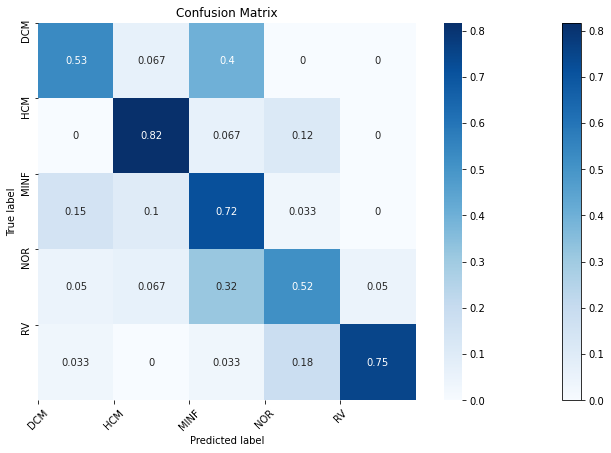

In [ ]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis =1)

y_test_tr = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test_tr, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.tight_layout()

class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
sns.heatmap(cm_normalized, cmap=plt.cm.Blues, annot=True)
plt.tight_layout()

tick_marks = np.arange(len(class_list))
plt.xticks(tick_marks, class_list, rotation=45)
plt.yticks(tick_marks, class_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def most_frequent(List): 
    return max(set(List), key = List.count) 

In [ ]:
y_au_pred = model.predict(X_test)

In [ ]:
final_result = list()
for patient in np.arange(0,300,6):
  list_1 = list()
  for slice_ in range(6):
      list_1.append(np.argmax(y_au_pred[(patient+slice_):(slice_+1+patient), :]))
      print((np.argmax(y_au_pred[(patient+slice_):(slice_+1+patient), :])))
  print('Most Frequent', most_frequent(list_1))
  print('-------------------------------------')
  print('Patient  ', patient)
  final_result.append(most_frequent(list_1))

2
2
2
2
1
2
Most Frequent 2
-------------------------------------
Patient   0
3
3
3
3
3
3
Most Frequent 3
-------------------------------------
Patient   6
1
2
2
2
2
2
Most Frequent 2
-------------------------------------
Patient   12
1
1
1
1
1
1
Most Frequent 1
-------------------------------------
Patient   18
1
2
1
1
1
1
Most Frequent 1
-------------------------------------
Patient   24
0
0
0
0
0
0
Most Frequent 0
-------------------------------------
Patient   30
0
3
3
3
3
3
Most Frequent 3
-------------------------------------
Patient   36
1
1
1
1
1
1
Most Frequent 1
-------------------------------------
Patient   42
3
3
3
4
3
3
Most Frequent 3
-------------------------------------
Patient   48
4
3
2
4
4
3
Most Frequent 4
-------------------------------------
Patient   54
1
1
1
1
1
1
Most Frequent 1
-------------------------------------
Patient   60
2
0
2
2
0
2
Most Frequent 2
-------------------------------------
Patient   66
0
0
0
0
0
0
Most Frequent 0
--------------------------

In [ ]:
def checking_up_results(model, X_test):
    y_pred = model.predict(X_test)
    final_result = list()
    for patient in np.arange(0,300,6):
      list_1 = list()
      for slice_ in range(6):
          list_1.append(np.argmax(y_pred[(patient+slice_):(slice_+1+patient), :]))
          # print((np.argmax(y_pred[(patient+slice_):(slice_+1+patient), :])))
      # print('Most Frequent', most_frequent(list_1))
      # print('-------------------------------------')
      # print('Patient  ', patient)
      final_result.append(most_frequent(list_1))

    return final_result

In [ ]:
y_true_list = [np.argmax(y_test[x, :]) for x in range(6)]

In [ ]:
final_result = checking_up_results(model, X_test)

In [ ]:
print(accuracy_score(y_test_, final_result))

0.72


In [ ]:
def metricas(y_pred, y_test_tr):
    cm = confusion_matrix(y_test_tr, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True)
    plt.tight_layout() 

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list, rotation=45, va='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test_tr,y_pred,target_names=class_list))

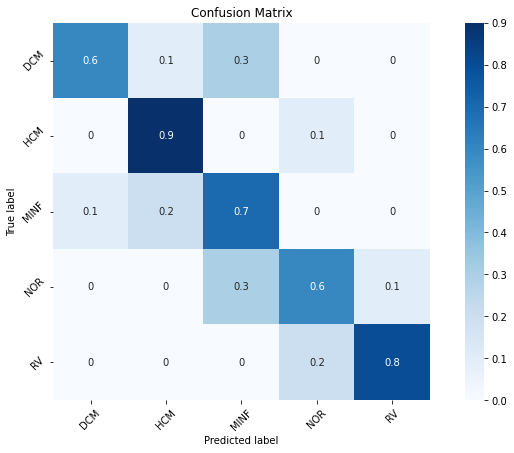

              precision    recall  f1-score   support

         DCM       0.86      0.60      0.71        10
         HCM       0.75      0.90      0.82        10
        MINF       0.54      0.70      0.61        10
         NOR       0.67      0.60      0.63        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.72        50
   macro avg       0.74      0.72      0.72        50
weighted avg       0.74      0.72      0.72        50



In [ ]:
metricas(final_result, y_test_)

Loading Best Model to obtain final Metrics

In [ ]:
alex_model = load_model("/content/gdrive/My Drive/Colab Notebooks/TFM/Models/AlexNet.hdf5")

In [ ]:
loss, accuracy = alex_model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 43ms/step - loss: 1.5669 - accuracy: 0.6933


In [ ]:
y_au_pred = alex_model.predict(X_test)

In [ ]:
final_result = checking_up_results(alex_model, X_test)

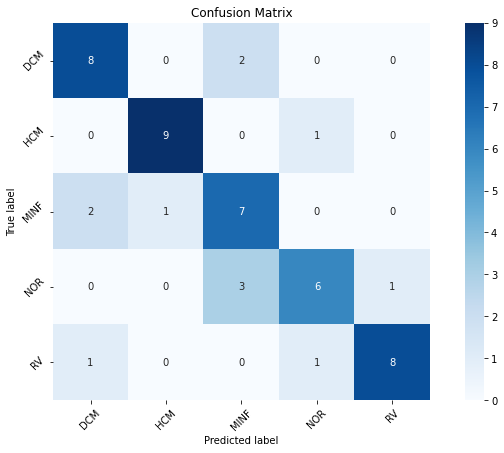

              precision    recall  f1-score   support

         DCM       0.73      0.80      0.76        10
         HCM       0.90      0.90      0.90        10
        MINF       0.58      0.70      0.64        10
         NOR       0.75      0.60      0.67        10
          RV       0.89      0.80      0.84        10

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50



In [ ]:
metricas(final_result, y_test_)